## Part V - Feature Engineering and Feature Store

University of San Diego - MS Applied AI

AAI-540 Team 5

October 21, 2024

In [1]:
# setup environment
%run 0-Environment_Setup.ipynb

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Stored 's3_datalake_path_csv' (str)
Stored 'local_data_path_csv' (str)
Stored 's3_datalake_path_parquet' (str)


### Get a rollup of total sales by store, by date

In [2]:
table_name = "cleaned_data"

# Define SQL query
statement = """SELECT 
    date,
    store_nbr,
    round(sum(sales), 2) as sales,
    max(dcoilwtico) as oil,
    max(onpromotion) as onpromotion,
    max(is_holiday) as is_holiday,
    max(city) as city,
    max(state) as state,
    max(cluster) as cluster
    FROM aai540finalprojectdb.cleaned_data
    GROUP BY (date, store_nbr)
ORDER BY date, store_nbr""".format(
    database_name, table_name
)

# get the results
store_sales_df = wr.athena.read_sql_query(statement, database_name)

2024-10-07 21:30:31,351	WARNING services.py:2009 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 411041792 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=0.83gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-10-07 21:30:32,770	INFO worker.py:1771 -- Started a local Ray instance.


In [3]:
len(store_sales_df)

90936

### Do some further cleanup

- Check for null values
- Impute as necessary

In [4]:
# check nulls in housing_gmaps_data
print(store_sales_df.isnull().sum())

date               0
store_nbr          0
sales              0
oil            25974
onpromotion        0
is_holiday         0
city               0
state              0
cluster            0
dtype: int64


In [5]:
# impute oil values using forward fill
store_sales_df['oil'].fillna(method='ffill', inplace=True)

/tmp/ipykernel_1575/331022032.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_sales_df['oil'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_1575/331022032.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  store_sales_df['oil'].fillna(method='ffill', inplace=True)


In [6]:
# double check all nulls are imputed
store_sales_df[store_sales_df['oil'].isnull()]

,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster


In [7]:
# break down date into year, month, day, day of week
store_sales_df["date"] = pd.to_datetime(store_sales_df["date"])
store_sales_df["year"] = store_sales_df["date"].dt.year
store_sales_df["month"] = store_sales_df["date"].dt.month
store_sales_df["day"] = store_sales_df["date"].dt.day
store_sales_df["dow"] = store_sales_df["date"].dt.dayofweek

In [8]:
# inspect
store_sales_df

,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,month,day,dow
0,2013-01-01,1,0.00,93.14,0,1,Quito,Pichincha,13,2013,1,1,1
1,2013-01-01,2,0.00,93.14,0,1,Quito,Pichincha,13,2013,1,1,1
2,2013-01-01,3,0.00,93.14,0,1,Quito,Pichincha,8,2013,1,1,1
3,2013-01-01,4,0.00,93.14,0,1,Quito,Pichincha,9,2013,1,1,1
4,2013-01-01,5,0.00,93.14,0,1,Santo Domingo,Santo Domingo de los Tsachilas,4,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90931,2017-08-15,50,16879.12,47.57,35,0,Ambato,Tungurahua,14,2017,8,15,1
90932,2017-08-15,51,20154.56,47.57,29,0,Guayaquil,Guayas,17,2017,8,15,1
90933,2017-08-15,52,18600.05,47.57,37,0,Manta,Manabi,11,2017,8,15,1
90934,2017-08-15,53,8208.19,47.57,33,0,Manta,Manabi,13,2017,8,15,1


### Encode Categorical Columns

In [9]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

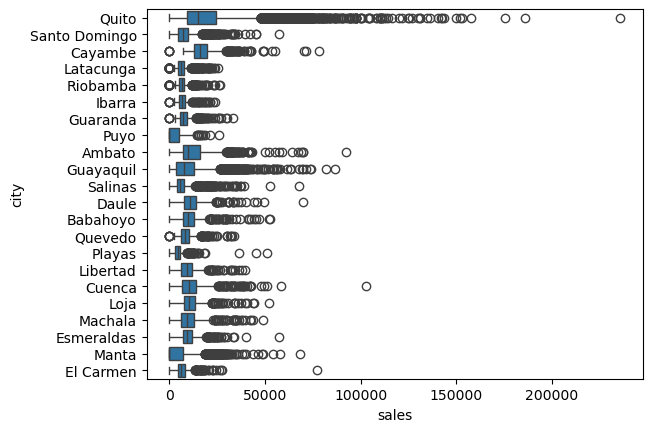

In [10]:
# City vs sales
sns.boxplot(data=store_sales_df, y='city', x='sales')
plt.show()

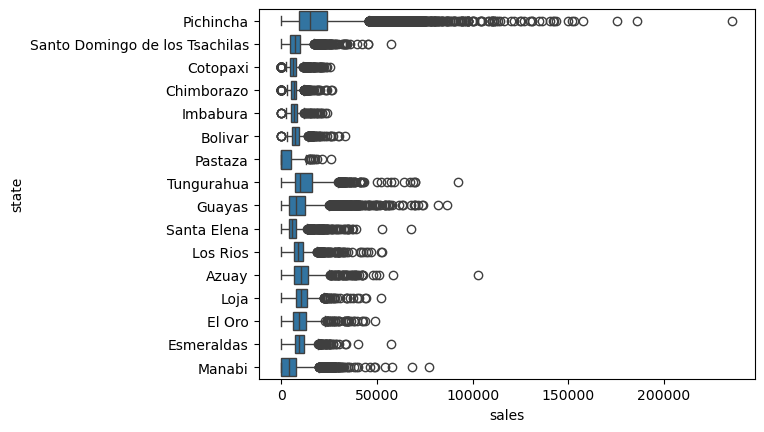

In [11]:
# State vs sales
sns.boxplot(data=store_sales_df, y='state', x='sales')
plt.show()

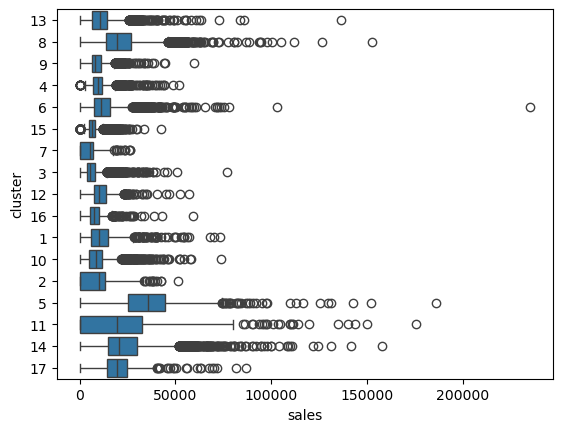

In [12]:
# Cluster vs sales
store_sales_df['cluster'] = store_sales_df['cluster'].astype(str)
sns.boxplot(data=store_sales_df, y='cluster', x='sales')
plt.show()

In [13]:
# Derive new variables combining city state and cluster
store_sales_df['city-state'] = store_sales_df['city'] + "-" + store_sales_df['state']
store_sales_df['city-state-cluster'] = store_sales_df['city'] + "-" + store_sales_df['state'] + "-" + store_sales_df['cluster'].astype('str')
store_sales_df.head()

,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,month,day,dow,city-state,city-state-cluster
0,2013-01-01,1,0.0,93.14,0,1,Quito,Pichincha,13,2013,1,1,1,Quito-Pichincha,Quito-Pichincha-13
1,2013-01-01,2,0.0,93.14,0,1,Quito,Pichincha,13,2013,1,1,1,Quito-Pichincha,Quito-Pichincha-13
2,2013-01-01,3,0.0,93.14,0,1,Quito,Pichincha,8,2013,1,1,1,Quito-Pichincha,Quito-Pichincha-8
3,2013-01-01,4,0.0,93.14,0,1,Quito,Pichincha,9,2013,1,1,1,Quito-Pichincha,Quito-Pichincha-9
4,2013-01-01,5,0.0,93.14,0,1,Santo Domingo,Santo Domingo de los Tsachilas,4,2013,1,1,1,Santo Domingo-Santo Domingo de los Tsachilas,Santo Domingo-Santo Domingo de los Tsachilas-4


In [14]:
print(f"Unique city-state values: {store_sales_df['city-state'].nunique()}")
print(f"Unique city-state-cluster values: {store_sales_df['city-state-cluster'].nunique()}")

Unique city-state values: 22
Unique city-state-cluster values: 41


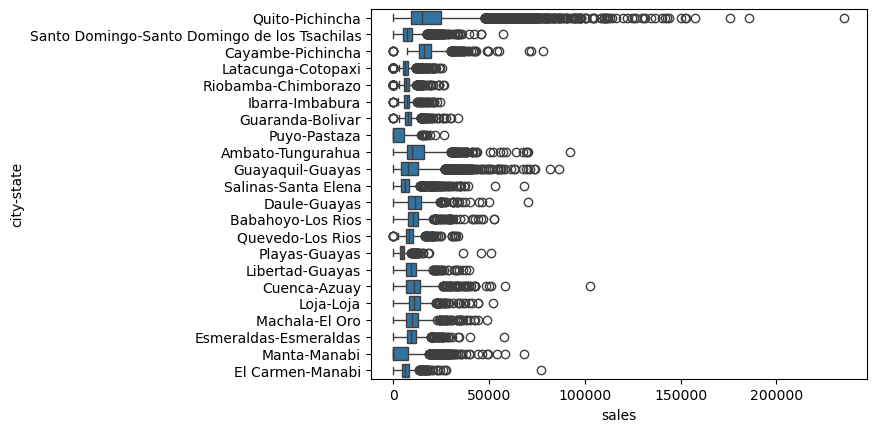

In [15]:
# City-state vs sales
sns.boxplot(data=store_sales_df, y='city-state', x='sales')
plt.show()

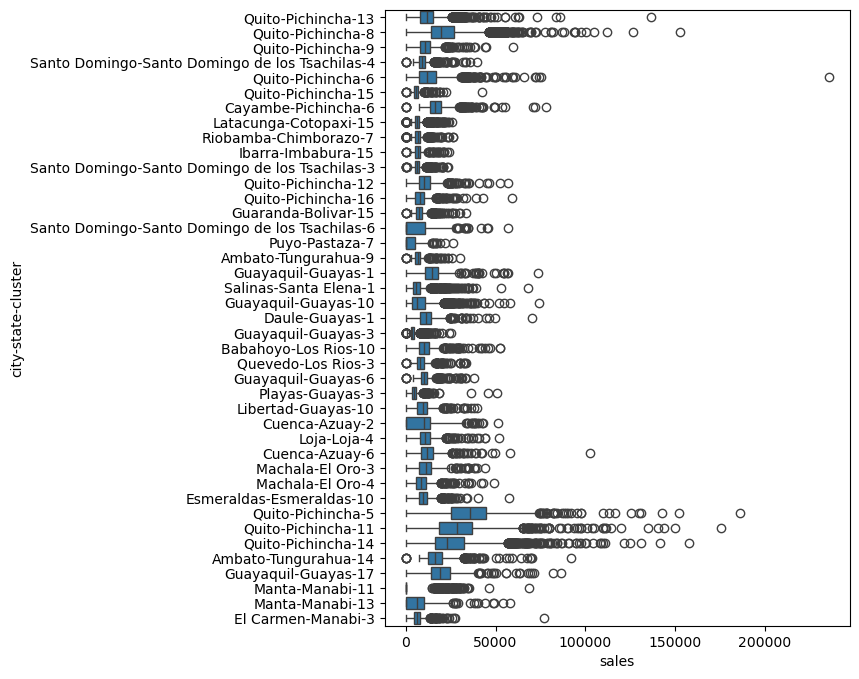

In [63]:
# City-state-cluster vs sales
plt.figure(figsize=(6, 8))
sns.boxplot(data=store_sales_df, y='city-state-cluster', x='sales')
plt.show()

In [16]:
from sklearn.feature_extraction import FeatureHasher

In [17]:
# Apply hash encoding to the non-temporal categorical variables
unique_cats = store_sales_df['city-state-cluster'].nunique()
#buckets = 2**math.floor(math.log(unique_cats, 2))
#buckets = math.floor(unique_cats/3)
buckets = 10
print(f"Using {buckets} buckets")

feature_hasher = FeatureHasher(n_features=buckets, input_type="string")
hashed_features = feature_hasher.transform(store_sales_df['city-state-cluster'].apply(lambda x: [x]))

hashed_feature_columns = [f'hash_{i}' for i in range(buckets)]
hashed_features_df = pd.DataFrame(hashed_features.toarray(), columns=hashed_feature_columns)

Using 10 buckets


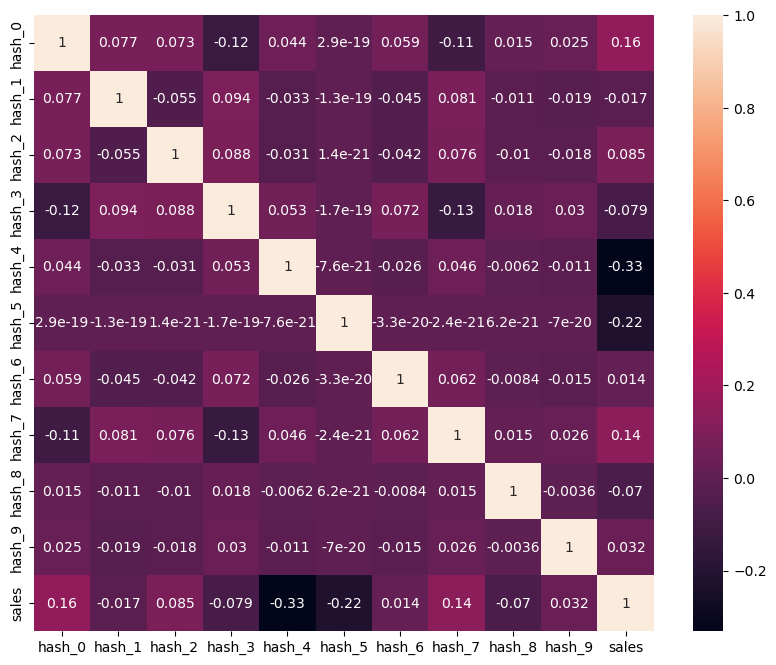

In [18]:
# Use a correlation matrix to try to identify the ideal number of buckets
temp_corr_df = pd.DataFrame(hashed_features.toarray(), columns=hashed_feature_columns)
temp_corr_df['sales'] = store_sales_df['sales']

corr = temp_corr_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True)
plt.show()

In [19]:
# Add hashed features to the data
store_sales_df = pd.concat([store_sales_df, hashed_features_df], axis=1)
store_sales_df.head()

,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,...,hash_0,hash_1,hash_2,hash_3,hash_4,hash_5,hash_6,hash_7,hash_8,hash_9
0,2013-01-01,1,0.0,93.14,0,1,Quito,Pichincha,13,2013,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-01,2,0.0,93.14,0,1,Quito,Pichincha,13,2013,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-01,3,0.0,93.14,0,1,Quito,Pichincha,8,2013,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
3,2013-01-01,4,0.0,93.14,0,1,Quito,Pichincha,9,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
4,2013-01-01,5,0.0,93.14,0,1,Santo Domingo,Santo Domingo de los Tsachilas,4,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
# use labelencoder to encode categorical columns
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

store_sales_df['city'] = le.fit_transform(store_sales_df['city'])
store_sales_df['state'] = le.fit_transform(store_sales_df['state'])

store_sales_df

,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,...,hash_0,hash_1,hash_2,hash_3,hash_4,hash_5,hash_6,hash_7,hash_8,hash_9
0,2013-01-01,1,0.00,93.14,0,1,18,12,13,2013,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-01,2,0.00,93.14,0,1,18,12,13,2013,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-01,3,0.00,93.14,0,1,18,12,8,2013,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
3,2013-01-01,4,0.00,93.14,0,1,18,12,9,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
4,2013-01-01,5,0.00,93.14,0,1,21,14,4,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90931,2017-08-15,50,16879.12,47.57,35,0,0,15,14,2017,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
90932,2017-08-15,51,20154.56,47.57,29,0,8,6,17,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
90933,2017-08-15,52,18600.05,47.57,37,0,14,10,11,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
90934,2017-08-15,53,8208.19,47.57,33,0,14,10,13,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0


In [21]:
# Apply angular distance encoding to temporal variables
store_sales_df['month_cos'] = store_sales_df['month'].apply(lambda month: np.cos(2*np.pi * (month/12)))
store_sales_df['month_sin'] = store_sales_df['month'].apply(lambda month: np.sin(2*np.pi * (month/12)))

store_sales_df['day_cos'] = store_sales_df['day'].apply(lambda day: np.cos(2*np.pi * (day/31)))
store_sales_df['day_sin'] = store_sales_df['day'].apply(lambda day: np.sin(2*np.pi * (day/31)))

store_sales_df['dow_cos'] = store_sales_df['dow'].apply(lambda dow: np.cos(2*np.pi * (dow/7)))
store_sales_df['dow_sin'] = store_sales_df['dow'].apply(lambda dow: np.sin(2*np.pi * (dow/7)))

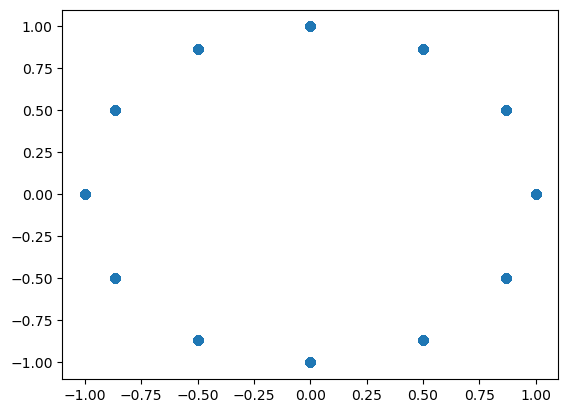

In [22]:
plt.scatter(store_sales_df['month_cos'], store_sales_df['month_sin'])
plt.show()

In [23]:
# convert date to format compatible with feature store
store_sales_df['date'] = store_sales_df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [24]:
# engineer id feature based on date and store_nbr
store_sales_df['sales_record_id'] = store_sales_df['date'].apply(lambda x: str(x)) + ":" + store_sales_df['store_nbr'].apply(lambda x: str(x))
store_sales_df

,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,...,hash_7,hash_8,hash_9,month_cos,month_sin,day_cos,day_sin,dow_cos,dow_sin,sales_record_id
0,2013-01-01,1,0.00,93.14,0,1,18,12,13,2013,...,0.0,0.0,0.0,0.866025,0.500000,0.979530,0.201299,0.62349,0.781831,2013-01-01:1
1,2013-01-01,2,0.00,93.14,0,1,18,12,13,2013,...,0.0,0.0,0.0,0.866025,0.500000,0.979530,0.201299,0.62349,0.781831,2013-01-01:2
2,2013-01-01,3,0.00,93.14,0,1,18,12,8,2013,...,0.0,0.0,0.0,0.866025,0.500000,0.979530,0.201299,0.62349,0.781831,2013-01-01:3
3,2013-01-01,4,0.00,93.14,0,1,18,12,9,2013,...,0.0,-1.0,0.0,0.866025,0.500000,0.979530,0.201299,0.62349,0.781831,2013-01-01:4
4,2013-01-01,5,0.00,93.14,0,1,21,14,4,2013,...,1.0,0.0,0.0,0.866025,0.500000,0.979530,0.201299,0.62349,0.781831,2013-01-01:5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90931,2017-08-15,50,16879.12,47.57,35,0,0,15,14,2017,...,0.0,0.0,0.0,-0.500000,-0.866025,-0.994869,0.101168,0.62349,0.781831,2017-08-15:50
90932,2017-08-15,51,20154.56,47.57,29,0,8,6,17,2017,...,0.0,-1.0,0.0,-0.500000,-0.866025,-0.994869,0.101168,0.62349,0.781831,2017-08-15:51
90933,2017-08-15,52,18600.05,47.57,37,0,14,10,11,2017,...,0.0,0.0,1.0,-0.500000,-0.866025,-0.994869,0.101168,0.62349,0.781831,2017-08-15:52
90934,2017-08-15,53,8208.19,47.57,33,0,14,10,13,2017,...,0.0,0.0,0.0,-0.500000,-0.866025,-0.994869,0.101168,0.62349,0.781831,2017-08-15:53


In [25]:
store_sales_df.dtypes

date                          object
store_nbr                      Int64
sales                        float64
oil                          float64
onpromotion                    Int64
is_holiday                     Int32
city                           int64
state                          int64
cluster                       object
year                           int32
month                          int32
day                            int32
dow                            int32
city-state            string[python]
city-state-cluster    string[python]
hash_0                       float64
hash_1                       float64
hash_2                       float64
hash_3                       float64
hash_4                       float64
hash_5                       float64
hash_6                       float64
hash_7                       float64
hash_8                       float64
hash_9                       float64
month_cos                    float64
month_sin                    float64
d

### Create Features and Feature Store

In [26]:
# helper function to convert col data types to non-objects
def cast_columns(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == "object":
            data_frame[label] = data_frame[label].astype("str").astype("string")
        elif data_frame.dtypes[label] == "bool":
            data_frame[label] = data_frame[label].astype("int")
            
cast_columns(store_sales_df)

In [27]:
# create fime feature
import time

current_time_sec = int(round(time.time()))

# set sales_record_id as primary key
record_identifier_feature_name = 'sales_record_id'
event_time_feature_name = "event_time"

# append EventTime feature
store_sales_df[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(store_sales_df), dtype="float64"
)

In [28]:
from time import gmtime, strftime, sleep
store_sales_feature_group.load_feature_definitions(data_frame=store_sales_df)

[FeatureDefinition(feature_name='date', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None),
 FeatureDefinition(feature_name='store_nbr', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='sales', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='oil', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='onpromotion', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='is_holiday', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='city', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='state', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='cluster', featur

In [29]:
# helper function to monitor feature group creation status
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

In [30]:
# Create Offline Feature Store

# create feature group
store_sales_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)

wait_for_feature_group_creation_complete(feature_group=store_sales_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup store-sales-feature-group-offline successfully created.


In [31]:
# ingest sales data
store_sales_feature_group.ingest(data_frame=store_sales_df, max_workers=3, wait=True)

IngestionManagerPandas(feature_group_name='store-sales-feature-group-offline', feature_definitions={'date': {'FeatureName': 'date', 'FeatureType': 'String'}, 'store_nbr': {'FeatureName': 'store_nbr', 'FeatureType': 'Integral'}, 'sales': {'FeatureName': 'sales', 'FeatureType': 'Fractional'}, 'oil': {'FeatureName': 'oil', 'FeatureType': 'Fractional'}, 'onpromotion': {'FeatureName': 'onpromotion', 'FeatureType': 'Integral'}, 'is_holiday': {'FeatureName': 'is_holiday', 'FeatureType': 'Integral'}, 'city': {'FeatureName': 'city', 'FeatureType': 'Integral'}, 'state': {'FeatureName': 'state', 'FeatureType': 'Integral'}, 'cluster': {'FeatureName': 'cluster', 'FeatureType': 'String'}, 'year': {'FeatureName': 'year', 'FeatureType': 'Integral'}, 'month': {'FeatureName': 'month', 'FeatureType': 'Integral'}, 'day': {'FeatureName': 'day', 'FeatureType': 'Integral'}, 'dow': {'FeatureName': 'dow', 'FeatureType': 'Integral'}, 'city-state': {'FeatureName': 'city-state', 'FeatureType': 'String'}, 'city-st

In [32]:
# Test a batch query
featurestore_runtime.batch_get_record(
    Identifiers=[
        {
            "FeatureGroupName": store_sales_feature_group_name,
            "RecordIdentifiersValueAsString": ["2017-08-15:1", "2017-08-15:2"],
        }
    ]
)

{'ResponseMetadata': {'RequestId': '2a7bae69-6a8b-4980-ba16-08c2ff35944f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2a7bae69-6a8b-4980-ba16-08c2ff35944f',
   'content-type': 'application/json',
   'content-length': '5418',
   'date': 'Mon, 07 Oct 2024 21:40:12 GMT'},
  'RetryAttempts': 0},
 'Records': [{'FeatureGroupName': 'store-sales-feature-group-offline',
   'RecordIdentifierValueAsString': '2017-08-15:2',
   'Record': [{'FeatureName': 'date', 'ValueAsString': '2017-08-15'},
    {'FeatureName': 'store_nbr', 'ValueAsString': '2'},
    {'FeatureName': 'sales', 'ValueAsString': '11196.26'},
    {'FeatureName': 'oil', 'ValueAsString': '47.57'},
    {'FeatureName': 'onpromotion', 'ValueAsString': '33'},
    {'FeatureName': 'is_holiday', 'ValueAsString': '0'},
    {'FeatureName': 'city', 'ValueAsString': '18'},
    {'FeatureName': 'state', 'ValueAsString': '12'},
    {'FeatureName': 'cluster', 'ValueAsString': '13'},
    {'FeatureName': 'year', 'ValueAsString': '20

### Load dataset from Offline Feature Store

In [33]:
store_sales_feature_group_resolved_output_s3_uri = (
    store_sales_feature_group.describe()
    .get("OfflineStoreConfig")
    .get("S3StorageConfig")
    .get("ResolvedOutputS3Uri")
)

store_sales_feature_group_s3_prefix = store_sales_feature_group_resolved_output_s3_uri.replace(
    f"s3://{default_s3_bucket_name}/", ""
)

offline_store_contents = None
while offline_store_contents is None:
    objects_in_bucket = s3_client.list_objects(
        Bucket=default_s3_bucket_name, Prefix=store_sales_feature_group_s3_prefix
    )
    if "Contents" in objects_in_bucket and len(objects_in_bucket["Contents"]) > 1:
        offline_store_contents = objects_in_bucket["Contents"]
    else:
        print("Waiting for data in offline store...\n")
        sleep(60)

print("Data available.")

Data available.


In [40]:
# test loading dataset from feature group
sales_features_timestamp = get_raw_dataset_from_offline_feature_group(store_sales_feature_group)

Running 
    SELECT *
    FROM
        "store_sales_feature_group_offline_1728336748"
    


In [41]:
# inspect the dataset
sales_features_timestamp

,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,...,month_sin,day_cos,day_sin,dow_cos,dow_sin,sales_record_id,event_time,write_time,api_invocation_time,is_deleted
0,2014-03-18,34,13382.88,100.08,0,0,8,6,6,2014,...,1.000000,-0.874347,-0.485302,0.623490,0.781831,2014-03-18:34,1.728337e+09,2024-10-07 21:43:10.885,2024-10-07 21:38:10.000,False
1,2017-04-17,28,13742.23,52.62,89,0,8,6,10,2017,...,0.866025,-0.954139,-0.299363,1.000000,0.000000,2017-04-17:28,1.728337e+09,2024-10-07 21:43:10.885,2024-10-07 21:38:11.000,False
2,2014-03-20,12,5542.89,99.68,0,0,10,3,15,2014,...,1.000000,-0.612106,-0.790776,-0.900969,0.433884,2014-03-20:12,1.728337e+09,2024-10-07 21:43:10.885,2024-10-07 21:38:11.000,False
3,2015-09-30,27,13110.94,45.06,199,0,4,6,1,2015,...,-1.000000,0.979530,-0.201299,-0.222521,0.974928,2015-09-30:27,1.728337e+09,2024-10-07 21:43:10.885,2024-10-07 21:38:11.000,False
4,2017-04-18,32,3992.15,52.46,73,0,8,6,3,2017,...,0.866025,-0.874347,-0.485302,0.623490,0.781831,2017-04-18:32,1.728337e+09,2024-10-07 21:43:10.885,2024-10-07 21:38:11.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90931,2015-09-26,26,4758.11,45.55,4,0,8,6,10,2015,...,-1.000000,0.528964,-0.848644,-0.222521,-0.974928,2015-09-26:26,1.728337e+09,2024-10-07 21:38:10.878,2024-10-07 21:38:08.000,False
90932,2017-04-15,13,9195.87,52.62,80,0,10,3,15,2017,...,0.866025,-0.994869,0.101168,-0.222521,-0.974928,2017-04-15:13,1.728337e+09,2024-10-07 21:38:10.878,2024-10-07 21:38:09.000,False
90933,2015-09-27,50,25581.26,45.55,24,0,0,15,14,2015,...,-1.000000,0.688967,-0.724793,0.623490,-0.781831,2015-09-27:50,1.728337e+09,2024-10-07 21:38:10.878,2024-10-07 21:38:09.000,False
90934,2014-03-17,45,32308.19,98.43,0,0,18,12,11,2014,...,1.000000,-0.954139,-0.299363,1.000000,0.000000,2014-03-17:45,1.728337e+09,2024-10-07 21:38:10.878,2024-10-07 21:38:10.000,False


: 

In [148]:
# get features stacked by store then date
sales_features_store = get_store_dataset_from_offline_feature_group(store_sales_feature_group)

Running 
    SELECT *
    FROM
        "store_sales_feature_group_offline_1728164033"
    ORDER BY
        store_nbr ASC, date ASC
    


In [149]:
# inspect
sales_features_store

,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,...,month_sin,day_cos,day_sin,dow_cos,dow_sin,sales_record_id,event_time,write_time,api_invocation_time,is_deleted
0,2013-01-01,1,0.00,93.14,0,1,18,12,13,2013,...,0.500000,0.979530,0.201299,0.623490,0.781831,2013-01-01:1,1.728164e+09,2024-10-05 21:39:49.912,2024-10-05 21:34:48.000,False
1,2013-01-02,1,7417.15,93.14,0,0,18,12,13,2013,...,0.500000,0.918958,0.394356,-0.222521,0.974928,2013-01-02:1,1.728164e+09,2024-10-05 21:39:49.924,2024-10-05 21:34:49.000,False
2,2013-01-03,1,5873.24,92.97,0,0,18,12,13,2013,...,0.500000,0.820763,0.571268,-0.900969,0.433884,2013-01-03:1,1.728164e+09,2024-10-05 21:39:50.018,2024-10-05 21:34:50.000,False
3,2013-01-04,1,5919.88,93.12,0,0,18,12,13,2013,...,0.500000,0.688967,0.724793,-0.900969,-0.433884,2013-01-04:1,1.728164e+09,2024-10-05 21:39:49.935,2024-10-05 21:34:50.000,False
4,2013-01-05,1,6318.79,93.12,0,1,18,12,13,2013,...,0.500000,0.528964,0.848644,-0.222521,-0.974928,2013-01-05:1,1.728164e+09,2024-10-05 21:39:50.006,2024-10-05 21:34:51.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90931,2017-08-11,54,8513.83,48.81,45,1,5,10,3,2017,...,-0.866025,-0.612106,0.790776,-0.900969,-0.433884,2017-08-11:54,1.728164e+09,2024-10-05 21:44:49.937,2024-10-05 21:40:23.000,False
90932,2017-08-12,54,9139.68,48.81,49,0,5,10,3,2017,...,-0.866025,-0.758758,0.651372,-0.222521,-0.974928,2017-08-12:54,1.728164e+09,2024-10-05 21:44:49.795,2024-10-05 21:40:24.000,False
90933,2017-08-13,54,14246.83,48.81,50,0,5,10,3,2017,...,-0.866025,-0.874347,0.485302,0.623490,-0.781831,2017-08-13:54,1.728164e+09,2024-10-05 21:44:49.786,2024-10-05 21:40:25.000,False
90934,2017-08-14,54,11882.99,47.59,46,0,5,10,3,2017,...,-0.866025,-0.954139,0.299363,1.000000,0.000000,2017-08-14:54,1.728164e+09,2024-10-05 21:44:49.846,2024-10-05 21:40:26.000,False
